## Introduction

### Definitions

##### Global Blocktree
A global tree maintained during the simulation used to determine certain statistics

##### Node Tree
A Node has a tree structure consisting of tree blocks just like in the Longest Chain Protocol.

##### Main Chain
On a tree structure, the main chain is defined in this protocol as the Longest Chain from the Genesis block to a leaf block.

##### Node Pool
A node also has a pool structure consisting of pool blocks. 

##### Tree Block
A block on the global blocktree or in a node's local tree.

##### Pool Block
A block in a node's local pool. The block may or may not be referenced by the next tree block proposed by the node.

##### Finalized
A block is considered finalized in two cases:

1) If in a tree block - if the block is `k` blocks deep on the main chain
2) If in a pool block - if the pool block is referenced by a tree block that is finalized

A transaction is considered finalized if it is in a finalized block

## Simulation Description

We measure multiple metrics to understand a transactions behavior during the simulation. 

#### Throughput
How many of the transactions generated actually get finalized in the simulation? 

#### Pool Block Arrival Latency
How long does it take for a transaction to make it into a pool block and get referenced?

#### Main Chain Arrival Latency
How long does it take for a transaction to make it onto the main chain?

#### Finalization Latency
How long does it take for a transaction to be finalized once it arrives on the main chain?


### Experimental Parameters

In [1]:
import numpy as np
%matplotlib inline

num_tests = 2

tree_proposal_rates = np.linspace(0.1, 0.1, num_tests)
pool_proposal_rates = np.linspace(0.1, 0.2, num_tests)
n_trials = 1
import json

# Create experimental parameters and write to JSON file

params = {'Block tree proposal rate parameter': 0,
 'Block pool proposal rate parameter': 0,
 'Block size (txs)': 50,
 'Duration (sec)': 0,
 'Fork choice rule': 'longest-chain-with-pool',
 'Network model': 'Decker-Wattenhorf',
 'Number of adversaries': 1,
 'Number of nodes': 100,
 'Probability of error in transaction confirmation': 0.1,
 'Transaction dataset': 'poisson',
 'Logging enabled': True}

### Run experiments

In [2]:
import os, shutil, pprint, glob, csv

pp = pprint.PrettyPrinter()
os.system('touch longest_chain_with_pool.json')
os.chdir('..')

import metrics

throughputs = {}
main_chain_arrival_latencies = {}
pool_block_latencies = {}
finalization_latencies = {}
hist_data = {}

for i in range(0, num_tests):
    tree_rate = tree_proposal_rates[i]
    pool_rate = pool_proposal_rates[i]
    params['Block tree proposal rate parameter'] = tree_rate
    params['Block pool proposal rate parameter'] = pool_rate
    params['Duration (sec)'] = 1000
    d = {}
    d['setting-name'] = f'longest-chain-with-pool'
    d[f'longest-chain-with-pool'] = params
    print('Parameters:')
    pp.pprint(d)
    with open('results/longest_chain_with_pool.json', 'w+') as outfile:
        json.dump(d, outfile)
    throughputs[(tree_rate, pool_rate)] = []
    main_chain_arrival_latencies[(tree_rate, pool_rate)] = []
    pool_block_latencies[(tree_rate, pool_rate)] = []
    finalization_latencies[(tree_rate, pool_rate)] = []
    for trial in range(0, n_trials):
        os.system('python3 main.py -f results/longest_chain_with_pool.json')
        throughput = metrics.compute_throughput()
        avg_main_chain_arrival_latency, avg_pool_block_latency, avg_finalization_latency = metrics.compute_latency()
        throughputs[(tree_rate, pool_rate)].append(throughput)
        main_chain_arrival_latencies[(tree_rate, pool_rate)].append(avg_main_chain_arrival_latency)
        pool_block_latencies[(tree_rate, pool_rate)].append(avg_pool_block_latency)
        finalization_latencies[(tree_rate, pool_rate)].append(avg_finalization_latency)
    
os.chdir('results/')
os.remove('longest_chain_with_pool.json')
print('Throughputs:\n', throughputs)
print('Main Chain Arrival Latencies:\n', main_chain_arrival_latencies)
print('Pool Block Latencies:\n', pool_block_latencies)
print('Finalization Latencies:\n', finalization_latencies)

Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.1,
                             'Block size (txs)': 50,
                             'Block tree proposal rate parameter': 0.1,
                             'Duration (sec)': 1000,
                             'Fork choice rule': 'longest-chain-with-pool',
                             'Logging enabled': True,
                             'Network model': 'Decker-Wattenhorf',
                             'Number of adversaries': 1,
                             'Number of nodes': 100,
                             'Probability of error in transaction confirmation': 0.1,
                             'Transaction dataset': 'poisson'},
 'setting-name': 'longest-chain-with-pool'}
Parameters:
{'longest-chain-with-pool': {'Block pool proposal rate parameter': 0.2,
                             'Block size (txs)': 50,
                             'Block tree proposal rate parameter': 0.1,
                            

### Compute Averages

Average throughput is the number of finalized transactions divided by the duration of the experiment.

Average main chain latency is the time for a transaction to be added to the global blocktree - the timestamp the transaction was generated.

Average pool block latency is the time for a transaction to be added to a pool block AND referenced by a tree block.

Average finalization latency is the time for a transaction to be k blocks deep - to be added to the global blocktree.

In [3]:
avg_throughputs = {}
for rate in throughputs:
    avg_throughputs[rate] = sum(throughputs[rate])/len(throughputs[rate])

print("Average Throughputs:", avg_throughputs)
    
avg_main_chain_latencies = {}
for rate in main_chain_arrival_latencies:
    avg_main_chain_latencies[rate] = sum(main_chain_arrival_latencies[rate])/len(main_chain_arrival_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_pool_block_latencies = {}
for rate in pool_block_latencies:
    avg_pool_block_latencies[rate] = sum(pool_block_latencies[rate])/len(pool_block_latencies[rate])

print("Average Main Chain Arrival Latency:", avg_main_chain_latencies)

avg_finalization_latencies = {}
for rate in finalization_latencies:
    avg_finalization_latencies[rate] = sum(finalization_latencies[rate])/len(finalization_latencies[rate])
    
print("Average Finalization Latency:", avg_finalization_latencies)

Average Throughputs: {(0.1, 0.1): 9.88, (0.1, 0.2): 10.03}
Average Main Chain Arrival Latency: {(0.1, 0.1): 12.96680799753465, (0.1, 0.2): 16.22541710525172}
Average Main Chain Arrival Latency: {(0.1, 0.1): 12.96680799753465, (0.1, 0.2): 16.22541710525172}
Average Finalization Latency: {(0.1, 0.1): 40.35417531816026, (0.1, 0.2): 25.67113173688363}


### Extract Finalization Depth and Delta for Blocks

In [4]:
import csv
with open('../logs/stats.csv', newline='') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        if row[0]=='Finalization depth':
            k = int(row[1])
        elif row[0]=='Average network latency for blocks (sec)':
            delta = float(row[1])

### Plotting the results

In [12]:
import matplotlib.pylab as plt
x = [key[1] for key in avg_main_chain_latencies.keys()]
y1 = avg_throughputs.values()
y2 = avg_main_chain_latencies.values()
y3 = avg_pool_block_latencies.values()
y4 = avg_finalization_latencies.values()

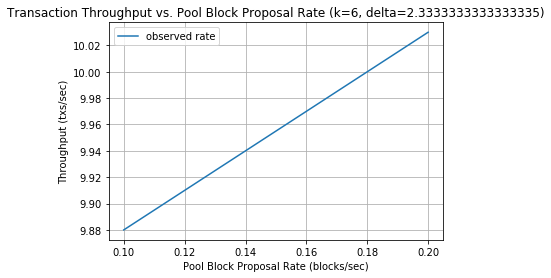

In [14]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Throughput (txs/sec)')
plt.title(f'Transaction Throughput vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y1, label='observed rate')
plt.legend()
plt.show()

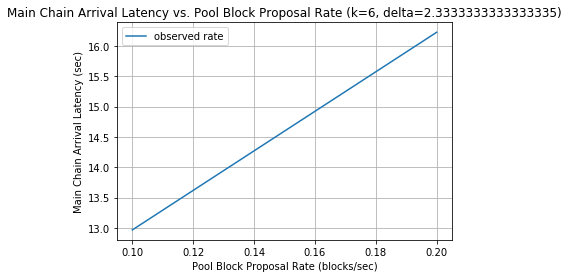

In [15]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Main Chain Arrival Latency (sec)')
plt.title(f'Main Chain Arrival Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

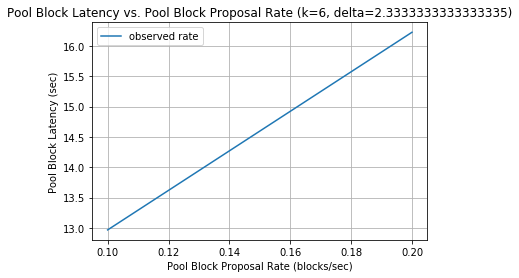

In [16]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Pool Block Latency (sec)')
plt.title(f'Pool Block Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)

plt.plot(x, y2, label='observed rate')
plt.legend()
plt.show()

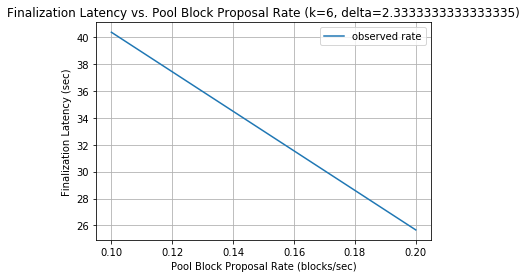

In [17]:
plt.xlabel('Pool Block Proposal Rate (blocks/sec)')
plt.ylabel('Finalization Latency (sec)')
plt.title(f'Finalization Latency vs. Pool Block Proposal Rate (k={k}, delta={delta})')
plt.grid(True)
plt.plot(x, y4, label='observed rate')
plt.legend()
plt.show()

### Results

We can look through the logs to understand the process a transaction undergoes:

In [18]:
import os

with open('../logs/transactions.csv') as csvfile:
    for line in csvfile.readlines()[:10]:
        print(line)

id,source node,generated timestamp,main chain arrival timestamp,pool block timestamp,finalization timestamp

9ce78d33bd,83,1.2836959615841461,23.770871657682843,23.770871657682843,59.868297013279225

8d2951a94b,71,0.7930900977821512,23.770871657682843,23.770871657682843,59.868297013279225

8c8865bdba,21,3.749472873605246,23.770871657682843,23.770871657682843,59.868297013279225

d5c01ddbf8,97,5.158689624283989,23.770871657682843,23.770871657682843,59.868297013279225

9b63522d62,58,9.710277785652895,23.770871657682843,23.770871657682843,59.868297013279225

cdaf7d718a,73,7.010932782236533,23.770871657682843,23.770871657682843,59.868297013279225

23a11490e9,75,7.237638228661663,23.770871657682843,23.770871657682843,59.868297013279225

fd4fa02540,23,7.559406339304722,23.770871657682843,23.770871657682843,59.868297013279225

54a2fdf022,41,8.30954576812619,23.770871657682843,23.770871657682843,59.868297013279225



In [19]:
with open('../logs/blocks.csv') as csvfile:
    for line in csvfile.readlines()[:10]:
        print(line)

id,parent id,proposal timestamp,pool block timestamp,finalization timestamp,depth,finalized,transactions

Genesis,None,0,None,50.51674080381895,0,True,

72dc1,Genesis,23.770871657682843,None,59.868297013279225,1,True,9ce78d33bd;8d2951a94b;8c8865bdba;d5c01ddbf8;9b63522d62;cdaf7d718a;23a11490e9;fd4fa02540;54a2fdf022;a819b3f910;01e6fd0089;6d1770352a;017ddd6a81;f030073f5a;ddd3cef889;13ca4b2b95;38e4653bab;e4273fd664;1b42a0a6d2;c0abb52e5a;bdc30da9b7;de0d87c4b5;e4ca4cea64;f7b7defa53;ece72a20fa;a6d25992c8;301e104472;757eddd986

41f21,None,5.399439215935607,,59.868297013279225,NA,True,9ce78d33bd;8d2951a94b;8c8865bdba

d3c44,None,13.329225651968754,,59.868297013279225,NA,True,9ce78d33bd;8d2951a94b;8c8865bdba;d5c01ddbf8;9b63522d62;cdaf7d718a;23a11490e9;fd4fa02540;54a2fdf022;a819b3f910;01e6fd0089;6d1770352a;017ddd6a81

639fb,72dc1,38.032727807606015,None,63.93505205435713,2,True,19b75abe0f;0bb4054dc6;a14f211a97;3de90f1c72;ec0533200b;e0fd63b1ed;8037d2a559;a8b2fa635e;049ad1cf71;79c4172f87;c55c0d159f